In [149]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
from matplotlib import pyplot as plt
%matplotlib inline
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./utility-vista-307720-6cec755818c9.json"
client = bigquery.Client()
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [150]:
zriall=pd.read_csv("Zip_Zri_AllHomesPlusMultifamily.csv")

In [151]:
zriall.rename(columns={"RegionName":"zipcode"},inplace=True)

In [152]:
#drop missing Metros since cannot impute from other values like City or zipcode
missingMetros = pd.isnull(zriall["Metro"])
zriall=zriall[~missingMetros]

In [172]:
zriall.rename(columns={"RegionName":"zipcode"},inplace=True)
phoenixall = zriall[zriall.Metro.str.contains('Phoenix')]
print(phoenixall.shape)

missingRowsAll = pd.isnull(phoenixall).sum(axis=1) > 0
missingColsAll = pd.isnull(phoenixall).sum(axis=0) > 0

#Dropping columns with more than 1/2 of a zipcode's data missing
for col in phoenixall.columns[missingColsAll]:
    if pd.isnull(phoenixall[col]).sum()>15:
        print(f"Dropping {col} from All")
        phoenixall.drop(col,axis=1,inplace=True)

#Dropping zipcodes with more than 40% of index data missing
phoenixall = phoenixall[pd.isnull(phoenixall).sum(axis=1)<50]
phoenixall['zipcode'].unique().astype(str)


(131, 120)
Dropping 2010-10 from All


/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array(['85032', '85281', '85225', '85308', '85142', '85251', '85282',
       '85383', '85204', '85345', '85301', '85022', '85008', '85255',
       '85201', '85326', '85351', '85338', '85205', '85374', '85254',
       '85248', '85207', '85122', '85016', '85224', '85283', '85209',
       '85018', '85382', '85260', '85044', '85029', '85041', '85206',
       '85234', '85020', '85295', '85208', '85021', '85202', '85296',
       '85249', '85286', '85027', '85226', '85015', '85051', '85086',
       '85033', '85120', '85302', '85210', '85138', '85035', '85379',
       '85042', '85233', '85213', '85037', '85257', '85023', '85339',
       '85212', '85143', '85140', '85048', '85014', '85323', '85395',
       '85392', '85268', '85203', '85050', '85009', '85331', '85017',
       '85053', '85340', '85353', '85396', '85119', '85024', '85132',
       '85335', '85013', '85085', '85040', '85381', '85304', '85303',
       '85388', '85306', '85006', '85373', '85250', '85043', '85215',
       '85028', '850

In [154]:
imputeCols = phoenixall.columns[7:]

In [157]:
missingRowsAllPost = pd.isnull(phoenixall).sum(axis=1) > 0
missingColsAllPost = pd.isnull(phoenixall).sum(axis=0) > 0
print(phoenixall.columns[missingColsAllPost])
#impute with front fill method
#may need to run this cell TWICE
phoenixall.loc[:,imputeCols] = phoenixall.loc[:,imputeCols].ffill()
print(phoenixall.shape)
print(phoenixall.columns[missingColsAllPost])

Index([], dtype='object')
(131, 119)
Index([], dtype='object')


In [159]:
print((pd.isnull(phoenixall_long).sum(axis=1) > 0).sum())
print((pd.isnull(phoenixall_long).sum(axis=0) > 0).sum())

0
0


In [158]:
valueCols=[col for col in phoenixall.columns if '20' in col] #columns with the indices
indexCols=[col for col in phoenixall.columns if '20' not in col] #columns without the indices
phoenixall_long=pd.melt(phoenixall, id_vars=indexCols, value_vars=valueCols, var_name="Period",value_name="ZRI")

<AxesSubplot:ylabel='Frequency'>

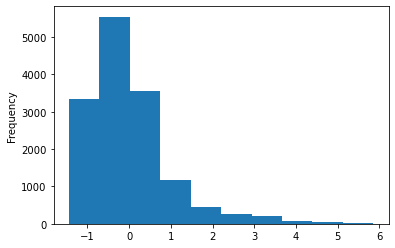

In [160]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
phoenixall_long["ZRI_norm"]=scaler.fit_transform(phoenixall_long[["ZRI"]]).flatten()
phoenixall_long["ZRI_norm"].plot.hist()

/Users/chitrasharathchandra/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:ylabel='Frequency'>

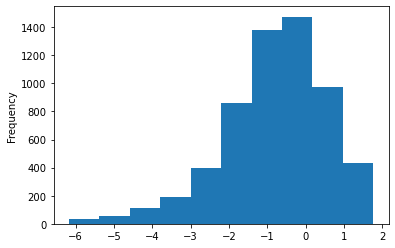

In [161]:
np.log(phoenixall_long["ZRI_norm"]).plot.hist()

In [162]:
phoenixall_long.loc[:,"Year"]=phoenixall_long["Period"].apply(lambda x: x.split("-")[0])
phoenixall_long.loc[:,"Month"]=phoenixall_long["Period"].apply(lambda x: x.split("-")[1])

In [163]:
phoenixall_long.to_csv("Phoenix_All_ZRI.csv")

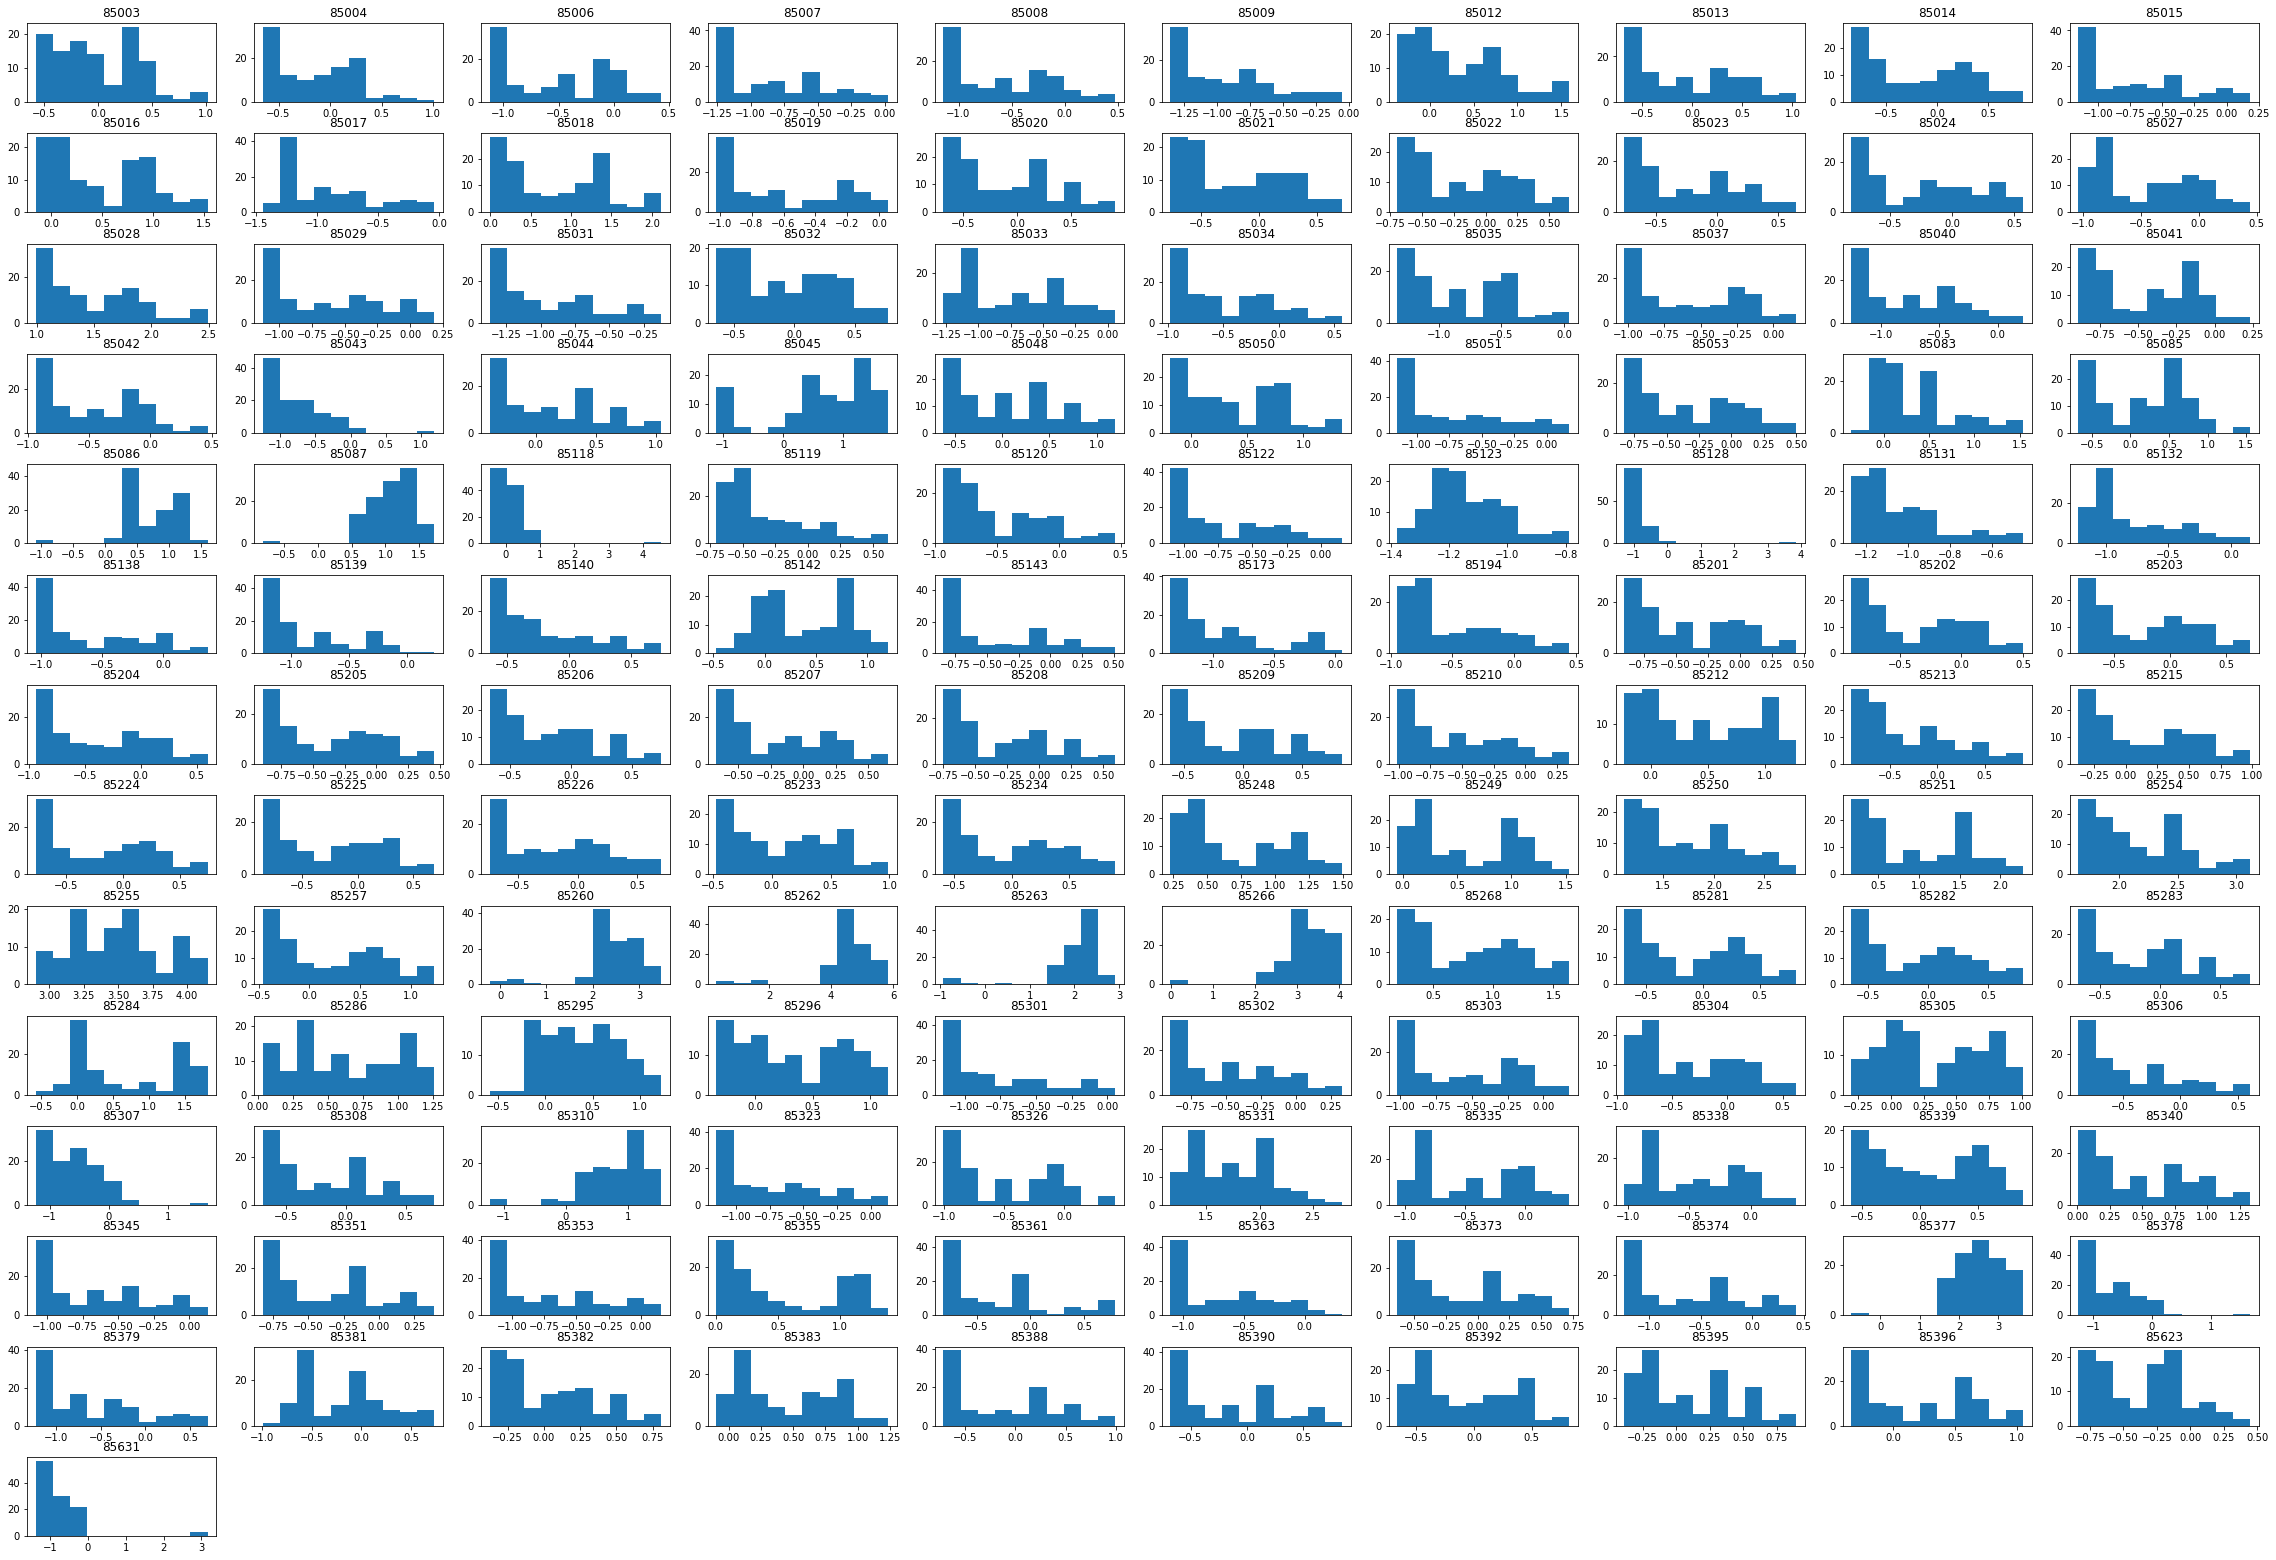

In [164]:
phoenixall_zipcode=phoenixall_long.groupby(["zipcode"])
plt.figure(figsize=(40,40))  
i=0
for zipcode,frame in phoenixall_zipcode:
    plt.subplot(20, 10, i+1)
    plt.hist(frame["ZRI_norm"])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    plt.title(zipcode)  
    i+=1
plt.show()

ValueError: num must be 1 <= num <= 17, not 18

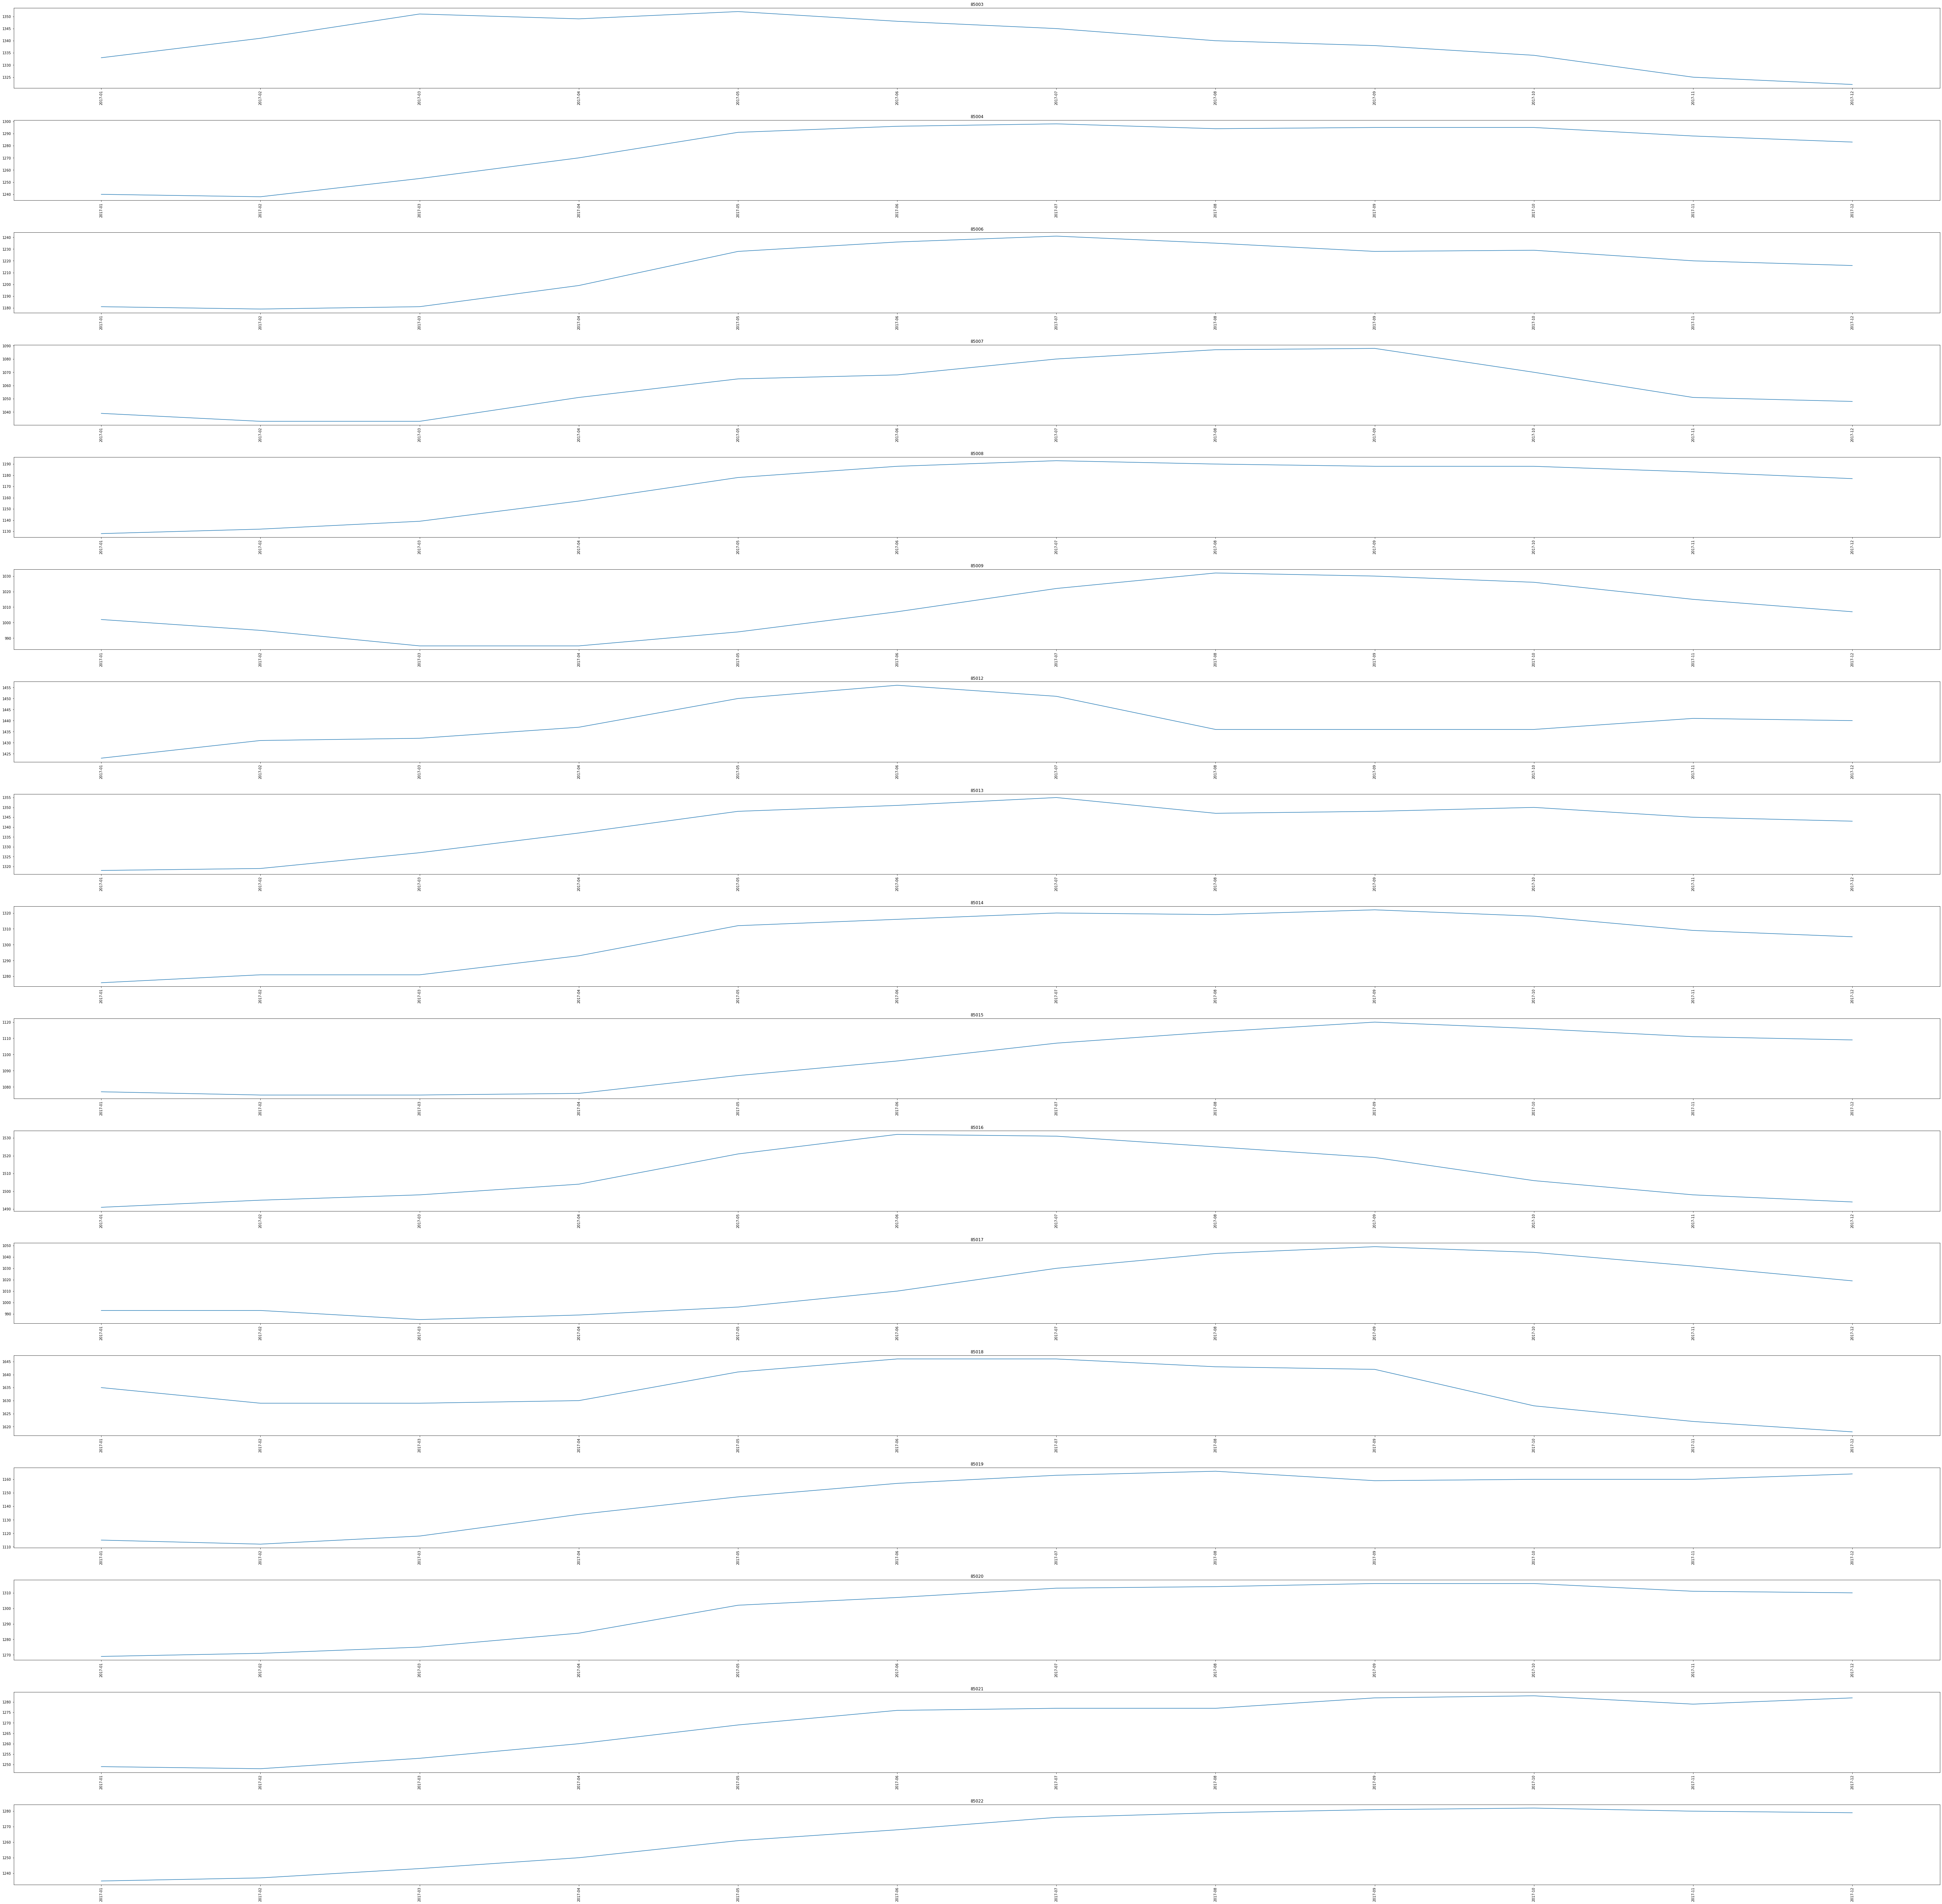

In [171]:
phoenixall_zipcode=phoenixall_long.groupby(["zipcode"])
plt.figure(figsize=(20,20))  # change the size of figure!
i=0
startYear=2017
for zipcode,frame in phoenixall_zipcode:
    newFrame=frame[frame["Period"].str.contains(str(startYear))]
    plt.subplot(17, 1, i+1)
    plt.plot(newFrame["Period"],newFrame["ZRI"])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    plt.title(zipcode)  # Plot title here!!!
    plt.xticks(rotation=90)
    i+=1
plt.show()